# Process Otovo data from 2017

Visualisations for dometstic solar production near Oslo (Norway) 2017

Requires following data sources, which have been downloaded and stored in the ./data folder.

* Transactions dataset: Downloaded from Otovo.no/minside "Last ned rådata" and containing all relevant information from the monthly electricity bill, stored in './data/2018-01-02 09_40_22.027629+00_00-transactions.csv'

* Solar production data (monthly), grabbed using the Chrome web inspector/developer tools from the SolarEdge portal and stored in './data/production.json'

* Hourly solar production data is included in the ./data folder but not utilised (yet)

Beware hackery :D YMMV

In [479]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "notebook_name = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [480]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import datetime
sns.set(style="whitegrid")

DATA_PATH='data'
OUTPUT_PATH= os.path.join('output', notebook_name)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [423]:
df = pd.read_csv(os.path.join(DATA_PATH,'2018-01-02 09_40_22.027629+00_00-transactions.csv'),
                skiprows=1,
                names=['time', 'type', 'estimate', 
                       'num_kwh', 'kwh_price_no_vat', 'vat_percent',
                       'amount_without_vat', 'amount_with_vat'],
                index_col=0,
                parse_dates=True)


In [424]:
df.head()

,type,estimate,num_kwh,kwh_price_no_vat,vat_percent,amount_without_vat,amount_with_vat
time,,,,,,,
2016-11-09 23:00:00,elcert,False,3.0,0.020,25,0.060,0.075
2016-11-09 23:00:00,consumption,False,3.0,0.354,25,1.061,1.327
2016-11-10 00:00:00,elcert,False,3.0,0.020,25,0.060,0.075
2016-11-10 00:00:00,consumption,False,3.0,0.349,25,1.048,1.311
2016-11-10 01:00:00,elcert,False,3.0,0.020,25,0.060,0.075


In [425]:
filename = os.path.join(DATA_PATH, 'production.json')
if filename:
    with open(filename, 'r') as f:
        production = json.load(f)

In [556]:
from pprint import pprint
prod17 = production['energy_chart_month'][1]['data']
print(prod17)

[0.041, 0.196, 0.62, 0.955, 1.101, 0.998, 1.179, 0.934, 0.447, 0.371, 0.105, 0.006]


In [581]:
#Total solar production 2017
tprod17 = sum(prod17)
print("%.0f kWh" % (tprod17*1000))

6953 kWh


In [582]:
#Total cost for the solar plant, factoring in the 15yr lease charge and the approximate discount from the Enova grant
cost17 = (899-115)*12
print("%.0f NOK" % cost17)

9408 NOK


In [583]:
#Cost per kWh of solar power produced, excluding any incomes derived from exporting solar power
cost17kwh = cost17/tprod17/1000
print("%.2f NOK/kWh" % cost17kwh)

# <- Clearly after the lease is repaid in years >15 then this will be zero.

1.35 NOK/kWh


In [584]:
#Average market price for grid energynettleie+kraft+avgifter 2017 (https://www.ssb.no/elkraftpris/)
# (NB this is actually higher than what I paid the grid from my usage pattern, 0.83 over the year)
#mkdpris = 0.952
mkdpris = 0.83
print("%0.2f NOK/kWh" % mkdpris )

0.83 NOK/kWh


In [585]:
# Cost to purchase the entire solar production for the grid at market average rate
purchase_cost = tprod17*mkdpris*1000
print("%0.2f NOK" % purchase_cost)

5770.99 NOK


In [586]:
# "EBIT" for Solar plant inn 2017
ebit = purchase_cost-cost17
print("%0.2f NOK" % ebit)

-3637.01 NOK


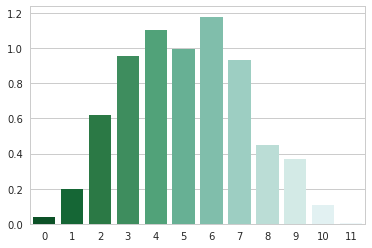

In [587]:
# Rough plot of production in kWH per month 2017
sns.barplot(list(range(0,12)), prod17, palette="BuGn_r")

# Notice poor production in June 17, in fact 25% worse than 2016

In [588]:
# Grab the imported grid electricity from the raw data and make it monthly
df_imports = df[df['type'] == 'consumption']
df_imports = df_imports.loc[datetime.date(2017,1,1):datetime.date(2017,12,31)]
df_imports['month'] = df_imports.index.month
df_imports_m = df_imports.groupby('month').agg({'num_kwh': ['sum'], 
                                                'amount_with_vat': ['sum']
                                               })
df_imports_m

,num_kwh,amount_with_vat
,sum,sum
month,,
1,3705.0,1283.601
2,3169.0,1115.142
3,2494.0,879.672
4,1616.0,558.843
5,1238.0,423.845
6,835.0,234.553
7,539.0,165.369
8,975.0,305.101


In [589]:
# Do the same with the solar exports to the grid
df_exports = df[df['type'] == 'production']
df_exports = df_exports.loc[datetime.date(2017,1,1):datetime.date(2017,12,31)]
df_exports['month'] = df_exports.index.month
df_exports_m = df_exports.groupby('month').agg({'num_kwh': ['sum'], 
                                                'amount_with_vat': ['sum']
                                               })
df_exports_m

,num_kwh,amount_with_vat
,sum,sum
month,,
3,20.0,-20.0
4,233.0,-233.0
5,502.0,-502.0
6,467.0,-467.0
7,717.0,-717.0
8,387.0,-387.0
9,134.0,-134.0
10,112.0,-112.0


In [590]:
# Merge the import export data into a single dataframe
df_exports_m.columns = ['exp_kwh', 'exp_amount_with_vat']
df_imports_m.columns = ['imp_kwh', 'imp_amount_with_vat']
df_impexp_m = df_imports_m.merge(df_exports_m, left_index=True, right_index=True, how='left')
df_impexp_m.fillna(0, inplace=True)
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat
month,,,,
1,3705.0,1283.601,0.0,0.0
2,3169.0,1115.142,0.0,0.0
3,2494.0,879.672,20.0,-20.0
4,1616.0,558.843,233.0,-233.0
5,1238.0,423.845,502.0,-502.0
6,835.0,234.553,467.0,-467.0
7,539.0,165.369,717.0,-717.0
8,975.0,305.101,387.0,-387.0
9,1335.0,470.571,134.0,-134.0


In [591]:
# Merge in the monthly solar production
se = pd.Series(prod17) * 1000
se.index = range(1, len(se)+1)
df_impexp_m['solar_prod_kwh'] = se
df_impexp_m.fillna(0, inplace=True)
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat,solar_prod_kwh
month,,,,,
1,3705.0,1283.601,0.0,0.0,41.0
2,3169.0,1115.142,0.0,0.0,196.0
3,2494.0,879.672,20.0,-20.0,620.0
4,1616.0,558.843,233.0,-233.0,955.0
5,1238.0,423.845,502.0,-502.0,1101.0
6,835.0,234.553,467.0,-467.0,998.0
7,539.0,165.369,717.0,-717.0,1179.0
8,975.0,305.101,387.0,-387.0,934.0
9,1335.0,470.571,134.0,-134.0,447.0


In [592]:
# Calculate how much solar power the house used (subtract exports from production)
df_impexp_m['solar_utilised_kwh'] = df_impexp_m['solar_prod_kwh'] - df_impexp_m['exp_kwh']
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat,solar_prod_kwh,solar_utilised_kwh
month,,,,,,
1,3705.0,1283.601,0.0,0.0,41.0,41.0
2,3169.0,1115.142,0.0,0.0,196.0,196.0
3,2494.0,879.672,20.0,-20.0,620.0,600.0
4,1616.0,558.843,233.0,-233.0,955.0,722.0
5,1238.0,423.845,502.0,-502.0,1101.0,599.0
6,835.0,234.553,467.0,-467.0,998.0,531.0
7,539.0,165.369,717.0,-717.0,1179.0,462.0
8,975.0,305.101,387.0,-387.0,934.0,547.0
9,1335.0,470.571,134.0,-134.0,447.0,313.0


In [593]:
# Calculate the total amount of grid+solar the propery used
df_impexp_m['grid_and_solar_used_kwh'] = df_impexp_m['solar_utilised_kwh'] + df_impexp_m['imp_kwh']
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat,solar_prod_kwh,solar_utilised_kwh,grid_and_solar_used_kwh
month,,,,,,,
1,3705.0,1283.601,0.0,0.0,41.0,41.0,3746.0
2,3169.0,1115.142,0.0,0.0,196.0,196.0,3365.0
3,2494.0,879.672,20.0,-20.0,620.0,600.0,3094.0
4,1616.0,558.843,233.0,-233.0,955.0,722.0,2338.0
5,1238.0,423.845,502.0,-502.0,1101.0,599.0,1837.0
6,835.0,234.553,467.0,-467.0,998.0,531.0,1366.0
7,539.0,165.369,717.0,-717.0,1179.0,462.0,1001.0
8,975.0,305.101,387.0,-387.0,934.0,547.0,1522.0
9,1335.0,470.571,134.0,-134.0,447.0,313.0,1648.0


In [594]:
# Totals
df_impexp_m.sum()

imp_kwh                    23405.000
imp_amount_with_vat         8264.971
exp_kwh                     2575.000
exp_amount_with_vat        -2575.000
solar_prod_kwh              6953.000
solar_utilised_kwh          4378.000
grid_and_solar_used_kwh    27783.000
dtype: float64

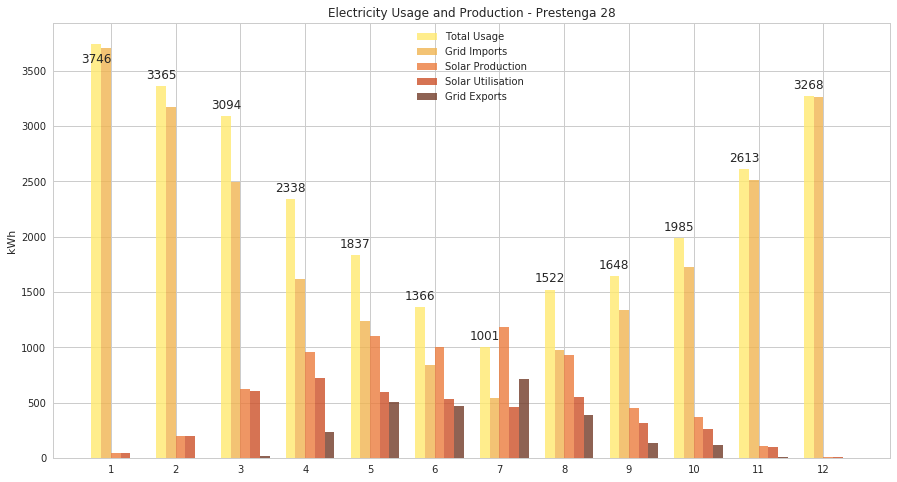

In [595]:
# Bar chart with various energy amounts by type
pos = list(range(len(df_impexp_m.index))) 
width = 0.15
f, ax = plt.subplots(figsize=(15, 8))

def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.05)
        else:
            label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height),
                ha='center', va='bottom')

r1 = ax.bar(pos, df_impexp_m['grid_and_solar_used_kwh'], width, alpha=0.8, color='#FFE96F', label='Total')
r2 = ax.bar([p + width for p in pos], df_impexp_m['imp_kwh'], width, alpha=0.8, color='#F0B551', label='Grid import')
r3 = ax.bar([p + width*2 for p in pos], df_impexp_m['solar_prod_kwh'], width, alpha=0.8, color='#EB7C3D', label = 'Solar production')
r4 = ax.bar([p + width*3 for p in pos], df_impexp_m['solar_utilised_kwh'], width, alpha=0.8, color='#CC5028', label='Solar utilisation')
r5 = ax.bar([p + width*4 for p in pos], df_impexp_m['exp_kwh'], width, alpha=0.8, color='#723B28', label='Grid export')

ax.set_ylabel('kWh')
ax.set_title('Electricity Usage and Production - Prestenga 28')
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df_impexp_m.index.values)

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*5)
#plt.ylim([0, max(df_impexp_m['grid_and_solar_used_kwh'])] )

autolabel(r1, ax)
#autolabel(r2, ax)
#autolabel(r3, ax)
#autolabel(r4, ax)
#autolabel(r5, ax)

# Adding the legend and showing the plot
plt.legend(['Total Usage', 'Grid Imports', 'Solar Production', 'Solar Utilisation', 'Grid Exports'], loc='upper center')
plt.show()

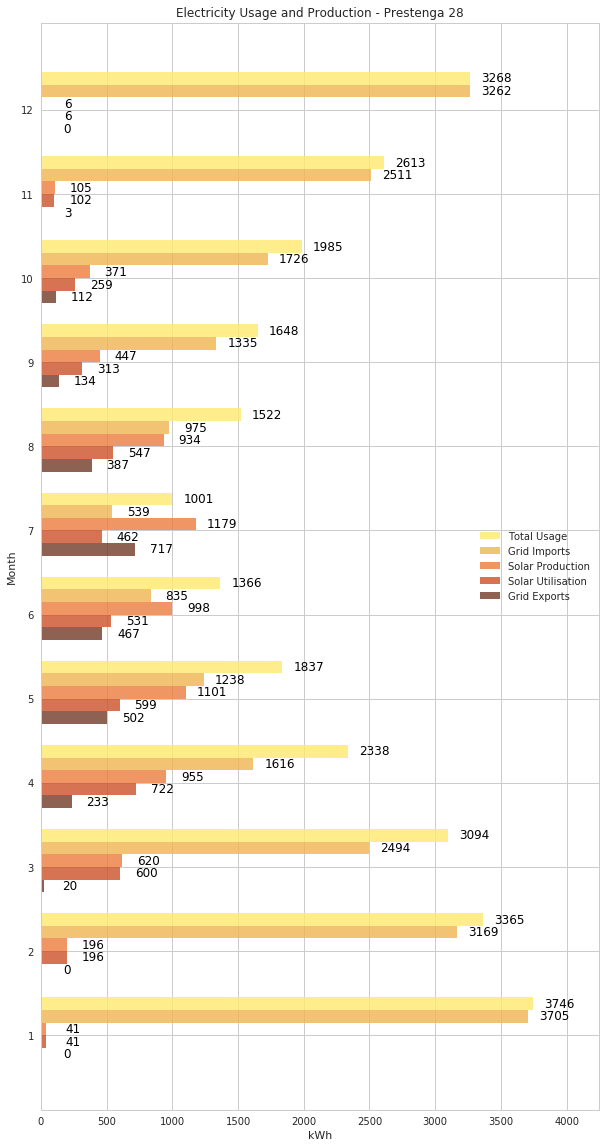

In [596]:
# Similar, but with horizontal layout

pos = list(range(len(df_impexp_m.index))) 
height = 0.15
f, ax = plt.subplots(figsize=(10,20))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text((rect.get_x() + rect.get_width())+200, rect.get_y() + rect.get_height()/2.,
                '%.f' % width,
                ha='center', va='center', color='black')

r1 = ax.barh([p + height*4 for p in pos], df_impexp_m['grid_and_solar_used_kwh'], height, alpha=0.8, color='#FFE96F', label='Total')
r2 = ax.barh([p + height*3 for p in pos], df_impexp_m['imp_kwh'], height, alpha=0.8, color='#F0B551', label='Grid import')
r3 = ax.barh([p + height*2 for p in pos], df_impexp_m['solar_prod_kwh'], height, alpha=0.8, color='#EB7C3D', label = 'Solar production')
r4 = ax.barh([p + height*1 for p in pos], df_impexp_m['solar_utilised_kwh'], height, alpha=0.8, color='#CC5028', label='Solar utilisation')
r5 = ax.barh(pos, df_impexp_m['exp_kwh'], height, alpha=0.8, color='#723B28', label='Grid export')

ax.set_ylabel('Month')
ax.set_xlabel('kWh')
ax.set_title('Electricity Usage and Production - Prestenga 28')
ax.set_yticks([p + 1.5 * height for p in pos])

# Set the labels for the x ticks
ax.set_yticklabels(df_impexp_m.index.values)

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*5)
plt.xlim([0, max(df_impexp_m['grid_and_solar_used_kwh'])+500] )

autolabel(r1)
autolabel(r2)
autolabel(r3)
autolabel(r4)
autolabel(r5)

# Adding the legend and showing the plot
plt.legend(['Total Usage', 'Grid Imports', 'Solar Production', 'Solar Utilisation', 'Grid Exports'], loc='center right')
plt.show()



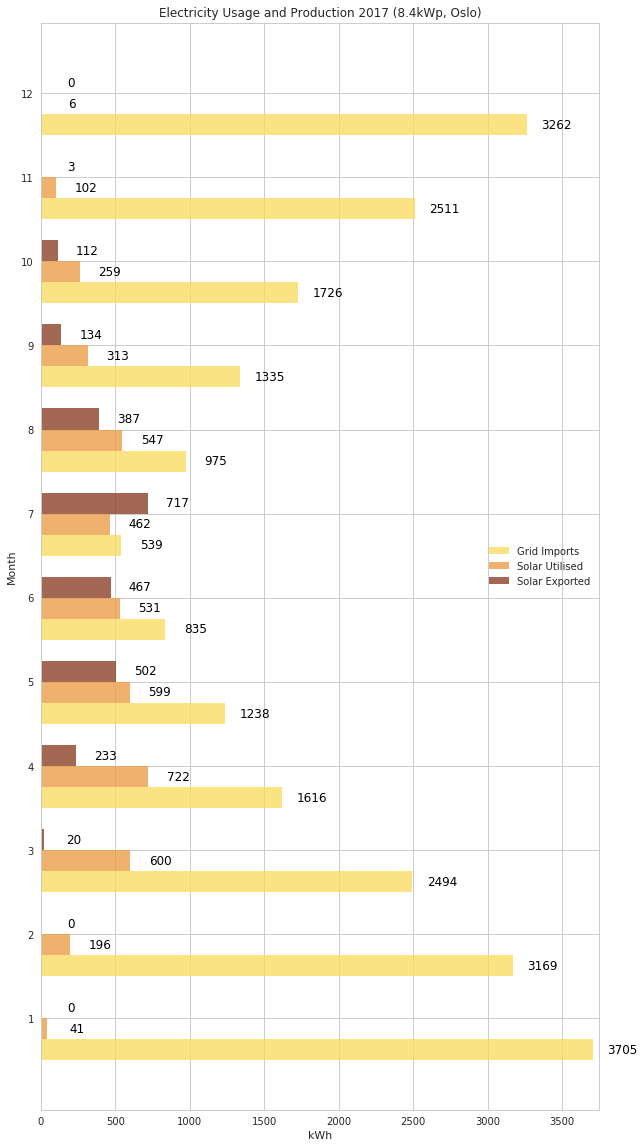

In [597]:
# Horizontal, less bars

pos = list(range(len(df_impexp_m.index))) 
height = 0.25
f, ax = plt.subplots(figsize=(10,20))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text((rect.get_x() + width)+200, rect.get_y() + rect.get_height()/2.,
                '%.f' % width,
                ha='center', va='center', color='black')


r1 = ax.barh(pos, df_impexp_m['imp_kwh'], height, alpha=0.8, color='#FADD66', label='Grid import')
r2 = ax.barh([p + height for p in pos], df_impexp_m['solar_utilised_kwh'], height, alpha=0.8, color='#EB9E4A', label='Solar utilised')
r3 = ax.barh([p + height*2 for p in pos], df_impexp_m['exp_kwh'], height, alpha=0.8, color='#8C4228', label='Grid export')


ax.set_ylabel('Month')
ax.set_xlabel('kWh')
ax.set_title('Electricity Usage and Production 2017 (8.4kWp, Oslo)')
ax.set_yticks([p + 1.5 * height for p in pos])

# Set the labels for the x ticks
ax.set_yticklabels(df_impexp_m.index.values)

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*5)
plt.xlim([0, max(df_impexp_m['solar_utilised_kwh'] + df_impexp_m['imp_kwh'])] )

autolabel(r1)
autolabel(r2)
autolabel(r3)


# Adding the legend and showing the plot
plt.legend(['Grid Imports', 'Solar Utilised', 'Solar Exported'], loc='center right')
plt.show()

In [598]:
# Calculate the "Nettleie" (Grid transmission) fees, based on list prices for Norges Nett (Follo/Røyken)
df_impexp_m['nettleie_fastledd'] = 2142/12.
df_impexp_m['nettleie_energiledd'] = 0.
df_impexp_m['nettleie_exp'] = 0.
df_impexp_m.loc[[5,6,7,8,9,10], 'nettleie_energiledd'] = df_impexp_m.loc[[5,6,7,8,9,10], 'imp_kwh'] * 39.83/100.
df_impexp_m.loc[[1,2,3,4,11,12], 'nettleie_energiledd'] = df_impexp_m.loc[[1,2,3,4,11,12], 'imp_kwh'] * 41.53/100.
df_impexp_m.loc[[5,6,7,8,9,10], 'nettleie_exp'] = df_impexp_m.loc[[5,6,7,8,9,10], 'exp_kwh'] * -1.67/100.
df_impexp_m.loc[[1,2,3,4,11,12], 'nettleie_exp'] = df_impexp_m.loc[[1,2,3,4,11,12], 'exp_kwh'] * -2.18/100.
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat,solar_prod_kwh,solar_utilised_kwh,grid_and_solar_used_kwh,nettleie_fastledd,nettleie_energiledd,nettleie_exp
month,,,,,,,,,,
1,3705.0,1283.601,0.0,0.0,41.0,41.0,3746.0,178.5,1538.6865,-0.0000
2,3169.0,1115.142,0.0,0.0,196.0,196.0,3365.0,178.5,1316.0857,-0.0000
3,2494.0,879.672,20.0,-20.0,620.0,600.0,3094.0,178.5,1035.7582,-0.4360
4,1616.0,558.843,233.0,-233.0,955.0,722.0,2338.0,178.5,671.1248,-5.0794
5,1238.0,423.845,502.0,-502.0,1101.0,599.0,1837.0,178.5,493.0954,-8.3834
6,835.0,234.553,467.0,-467.0,998.0,531.0,1366.0,178.5,332.5805,-7.7989
7,539.0,165.369,717.0,-717.0,1179.0,462.0,1001.0,178.5,214.6837,-11.9739
8,975.0,305.101,387.0,-387.0,934.0,547.0,1522.0,178.5,388.3425,-6.4629
9,1335.0,470.571,134.0,-134.0,447.0,313.0,1648.0,178.5,531.7305,-2.2378


In [599]:
# Reorder to put the money columns at the far right
df_all = df_impexp_m[[c for c in df_impexp_m if c not in ['imp_amount_with_vat', 'exp_amount_with_vat']] + ['imp_amount_with_vat', 'exp_amount_with_vat']]
df_all

,imp_kwh,exp_kwh,solar_prod_kwh,solar_utilised_kwh,grid_and_solar_used_kwh,nettleie_fastledd,nettleie_energiledd,nettleie_exp,imp_amount_with_vat,exp_amount_with_vat
month,,,,,,,,,,
1,3705.0,0.0,41.0,41.0,3746.0,178.5,1538.6865,-0.0000,1283.601,0.0
2,3169.0,0.0,196.0,196.0,3365.0,178.5,1316.0857,-0.0000,1115.142,0.0
3,2494.0,20.0,620.0,600.0,3094.0,178.5,1035.7582,-0.4360,879.672,-20.0
4,1616.0,233.0,955.0,722.0,2338.0,178.5,671.1248,-5.0794,558.843,-233.0
5,1238.0,502.0,1101.0,599.0,1837.0,178.5,493.0954,-8.3834,423.845,-502.0
6,835.0,467.0,998.0,531.0,1366.0,178.5,332.5805,-7.7989,234.553,-467.0
7,539.0,717.0,1179.0,462.0,1001.0,178.5,214.6837,-11.9739,165.369,-717.0
8,975.0,387.0,934.0,547.0,1522.0,178.5,388.3425,-6.4629,305.101,-387.0
9,1335.0,134.0,447.0,313.0,1648.0,178.5,531.7305,-2.2378,470.571,-134.0


In [606]:
# What would it cost if all the energy came from the grid and there was no solar involved?

# For grid power, use the rate that was paid that month
df_impexp_m['grid_kraft'] = df_impexp_m['imp_amount_with_vat']/df_impexp_m['imp_kwh'] * df_impexp_m['grid_and_solar_used_kwh']

# List prices for nettleie
df_impexp_m['grid_nett_energi'] = 0
df_impexp_m.loc[[5,6,7,8,9,10], 'grid_nett_energi'] = df_impexp_m.loc[[5,6,7,8,9,10], 'grid_and_solar_used_kwh'] * 39.83/100.
df_impexp_m.loc[[1,2,3,4,11,12], 'grid_nett_energi'] = df_impexp_m.loc[[1,2,3,4,11,12], 'grid_and_solar_used_kwh'] * 41.53/100.

df_impexp_m['grid_total'] = df_impexp_m['grid_kraft'] + df_impexp_m['grid_nett_energi'] + df_impexp_m['nettleie_fastledd']
df_impexp_m['grid_total_per_kwh'] = df_impexp_m['grid_total']/df_impexp_m['grid_and_solar_used_kwh']
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat,solar_prod_kwh,solar_utilised_kwh,grid_and_solar_used_kwh,nettleie_fastledd,nettleie_energiledd,nettleie_exp,grid_kraft,grid_nett_energi,grid_total,grid_total_per_kwh,solar_lease_amt,blend_kraft,blend_nettleie,blend_total,blend_total_per_kwh
month,,,,,,,,,,,,,,,,,,,
1,3705.0,1283.601,0.0,0.0,41.0,41.0,3746.0,178.5,1538.6865,-0.0000,1297.805491,1555.7138,3032.019291,0.809402,784.0,1283.601,1717.1865,3784.7875,1.010354
2,3169.0,1115.142,0.0,0.0,196.0,196.0,3365.0,178.5,1316.0857,-0.0000,1184.112600,1397.4845,2760.097100,0.820237,784.0,1115.142,1494.5857,3393.7277,1.008537
3,2494.0,879.672,20.0,-20.0,620.0,600.0,3094.0,178.5,1035.7582,-0.4360,1091.301190,1284.9382,2554.739390,0.825708,784.0,859.672,1213.8222,2857.4942,0.917628
4,1616.0,558.843,233.0,-233.0,955.0,722.0,2338.0,178.5,671.1248,-5.0794,808.524093,970.9714,1957.995493,0.837466,784.0,325.843,844.5454,1954.3884,0.760167
5,1238.0,423.845,502.0,-502.0,1101.0,599.0,1837.0,178.5,493.0954,-8.3834,628.920246,731.6771,1539.097346,0.837832,784.0,-78.155,663.2120,1369.0570,0.585317
6,835.0,234.553,467.0,-467.0,998.0,531.0,1366.0,178.5,332.5805,-7.7989,383.711854,544.0778,1106.289654,0.809875,784.0,-232.447,503.2816,1054.8346,0.575469
7,539.0,165.369,717.0,-717.0,1179.0,462.0,1001.0,178.5,214.6837,-11.9739,307.113857,398.6983,884.312157,0.883429,784.0,-551.631,381.2098,613.5788,0.357147
8,975.0,305.101,387.0,-387.0,934.0,547.0,1522.0,178.5,388.3425,-6.4629,476.270484,606.2126,1260.983084,0.828504,784.0,-81.899,560.3796,1262.4806,0.661331
9,1335.0,470.571,134.0,-134.0,447.0,313.0,1648.0,178.5,531.7305,-2.2378,580.899631,656.3984,1415.798031,0.859101,784.0,336.571,707.9927,1828.5637,1.026130


In [607]:
# What did it actually cost - with blended solar and grid?
# Have left out the "Elsertifikater" and a couple of small admin fees ..
df_impexp_m['solar_lease_amt'] = cost17/12
df_impexp_m['blend_kraft'] = df_impexp_m['imp_amount_with_vat'] + df_impexp_m['exp_amount_with_vat']
df_impexp_m['blend_nettleie'] = df_impexp_m['nettleie_fastledd'] + df_impexp_m['nettleie_energiledd'] + df_impexp_m['nettleie_exp']
df_impexp_m['blend_total'] = df_impexp_m['solar_lease_amt'] + df_impexp_m['blend_kraft'] + df_impexp_m['blend_nettleie']
df_impexp_m['blend_total_per_kwh'] = df_impexp_m['blend_total']/(df_impexp_m['imp_kwh'] + df_impexp_m['solar_prod_kwh'])
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat,solar_prod_kwh,solar_utilised_kwh,grid_and_solar_used_kwh,nettleie_fastledd,nettleie_energiledd,nettleie_exp,grid_kraft,grid_nett_energi,grid_total,grid_total_per_kwh,solar_lease_amt,blend_kraft,blend_nettleie,blend_total,blend_total_per_kwh
month,,,,,,,,,,,,,,,,,,,
1,3705.0,1283.601,0.0,0.0,41.0,41.0,3746.0,178.5,1538.6865,-0.0000,1297.805491,1555.7138,3032.019291,0.809402,784.0,1283.601,1717.1865,3784.7875,1.010354
2,3169.0,1115.142,0.0,0.0,196.0,196.0,3365.0,178.5,1316.0857,-0.0000,1184.112600,1397.4845,2760.097100,0.820237,784.0,1115.142,1494.5857,3393.7277,1.008537
3,2494.0,879.672,20.0,-20.0,620.0,600.0,3094.0,178.5,1035.7582,-0.4360,1091.301190,1284.9382,2554.739390,0.825708,784.0,859.672,1213.8222,2857.4942,0.917628
4,1616.0,558.843,233.0,-233.0,955.0,722.0,2338.0,178.5,671.1248,-5.0794,808.524093,970.9714,1957.995493,0.837466,784.0,325.843,844.5454,1954.3884,0.760167
5,1238.0,423.845,502.0,-502.0,1101.0,599.0,1837.0,178.5,493.0954,-8.3834,628.920246,731.6771,1539.097346,0.837832,784.0,-78.155,663.2120,1369.0570,0.585317
6,835.0,234.553,467.0,-467.0,998.0,531.0,1366.0,178.5,332.5805,-7.7989,383.711854,544.0778,1106.289654,0.809875,784.0,-232.447,503.2816,1054.8346,0.575469
7,539.0,165.369,717.0,-717.0,1179.0,462.0,1001.0,178.5,214.6837,-11.9739,307.113857,398.6983,884.312157,0.883429,784.0,-551.631,381.2098,613.5788,0.357147
8,975.0,305.101,387.0,-387.0,934.0,547.0,1522.0,178.5,388.3425,-6.4629,476.270484,606.2126,1260.983084,0.828504,784.0,-81.899,560.3796,1262.4806,0.661331
9,1335.0,470.571,134.0,-134.0,447.0,313.0,1648.0,178.5,531.7305,-2.2378,580.899631,656.3984,1415.798031,0.859101,784.0,336.571,707.9927,1828.5637,1.026130


In [608]:
# Totals
df_impexp_m[['grid_total', 'blend_total', 'solar_lease_amt', 'exp_amount_with_vat' ]].sum()

# grid_total is what it would have cost without solar panels
# blend_total is what was actually paid for grid + solar electricity, minus exports
# solar_lease_amount is the cost of the solar system (financed over 15 years)
# exp_amount_with_vat is the value of the solar power exported

grid_total             23235.544527
blend_total            26802.743400
solar_lease_amt         9408.000000
exp_amount_with_vat    -2575.000000
dtype: float64

In [610]:
# Difference between solar and just using the grid
print("EBIT: %0.2f NOK" % (df_impexp_m['grid_total'].sum() - df_impexp_m['blend_total'].sum()))

EBIT: -3567.20 NOK


In [611]:
# What does this look like in per kwh terms
df_impexp_m[['grid_total_per_kwh', 'blend_total_per_kwh']].mean()

grid_total_per_kwh     0.838744
blend_total_per_kwh    0.845489
dtype: float64

In [612]:
# append temperature
df_impexp_m['temp_ute_avg'] = [-2.2, -2.1, 2.1, 4.7, 10.7, 14.3, 16.0, 14.4, 11.3, 6.7, 1.0, -2.2]
df_impexp_m

,imp_kwh,imp_amount_with_vat,exp_kwh,exp_amount_with_vat,solar_prod_kwh,solar_utilised_kwh,grid_and_solar_used_kwh,nettleie_fastledd,nettleie_energiledd,nettleie_exp,grid_kraft,grid_nett_energi,grid_total,grid_total_per_kwh,solar_lease_amt,blend_kraft,blend_nettleie,blend_total,blend_total_per_kwh,temp_ute_avg
month,,,,,,,,,,,,,,,,,,,,
1,3705.0,1283.601,0.0,0.0,41.0,41.0,3746.0,178.5,1538.6865,-0.0000,1297.805491,1555.7138,3032.019291,0.809402,784.0,1283.601,1717.1865,3784.7875,1.010354,-2.2
2,3169.0,1115.142,0.0,0.0,196.0,196.0,3365.0,178.5,1316.0857,-0.0000,1184.112600,1397.4845,2760.097100,0.820237,784.0,1115.142,1494.5857,3393.7277,1.008537,-2.1
3,2494.0,879.672,20.0,-20.0,620.0,600.0,3094.0,178.5,1035.7582,-0.4360,1091.301190,1284.9382,2554.739390,0.825708,784.0,859.672,1213.8222,2857.4942,0.917628,2.1
4,1616.0,558.843,233.0,-233.0,955.0,722.0,2338.0,178.5,671.1248,-5.0794,808.524093,970.9714,1957.995493,0.837466,784.0,325.843,844.5454,1954.3884,0.760167,4.7
5,1238.0,423.845,502.0,-502.0,1101.0,599.0,1837.0,178.5,493.0954,-8.3834,628.920246,731.6771,1539.097346,0.837832,784.0,-78.155,663.2120,1369.0570,0.585317,10.7
6,835.0,234.553,467.0,-467.0,998.0,531.0,1366.0,178.5,332.5805,-7.7989,383.711854,544.0778,1106.289654,0.809875,784.0,-232.447,503.2816,1054.8346,0.575469,14.3
7,539.0,165.369,717.0,-717.0,1179.0,462.0,1001.0,178.5,214.6837,-11.9739,307.113857,398.6983,884.312157,0.883429,784.0,-551.631,381.2098,613.5788,0.357147,16.0
8,975.0,305.101,387.0,-387.0,934.0,547.0,1522.0,178.5,388.3425,-6.4629,476.270484,606.2126,1260.983084,0.828504,784.0,-81.899,560.3796,1262.4806,0.661331,14.4
9,1335.0,470.571,134.0,-134.0,447.0,313.0,1648.0,178.5,531.7305,-2.2378,580.899631,656.3984,1415.798031,0.859101,784.0,336.571,707.9927,1828.5637,1.026130,11.3


In [613]:
# export to file
df_impexp_m.to_csv(path_or_buf=os.path.join(OUTPUT_PATH, '2017_solar_summary.csv'))

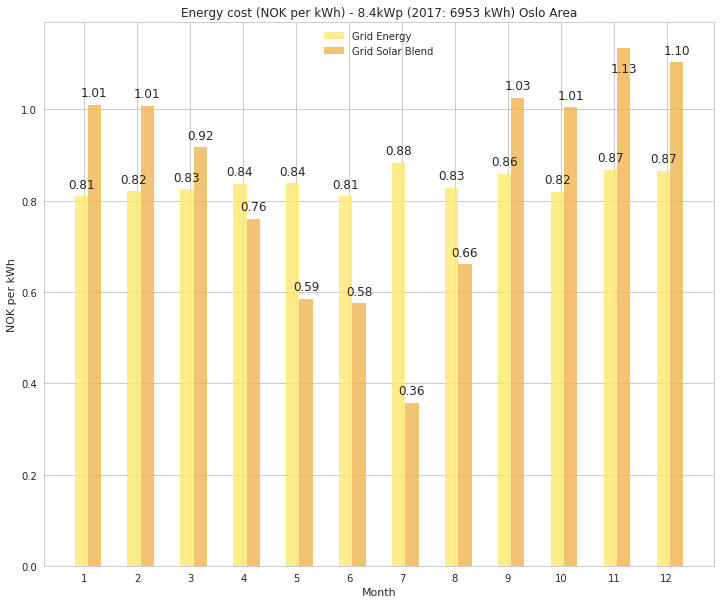

In [625]:
# chart grid and blended energy cost per month
pos = list(range(len(df_impexp_m.index))) 
width = 0.25
f, ax = plt.subplots(figsize=(12, 10))

def autolabel(rects, ax):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in rects:
        height = rect.get_height()

        # Fraction of axis height taken up by this rectangle
        p_height = (height / y_height)

        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column.
        if p_height > 0.95: # arbitrary; 95% looked good to me.
            label_position = height - (y_height * 0.05)
        else:
            label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%0.2f' % height,
                ha='center', va='bottom')

r1 = ax.bar(pos, df_impexp_m['grid_total_per_kwh'], width, alpha=0.8, color='#FFE96F', label='Grid')
r2 = ax.bar([p + width for p in pos], df_impexp_m['blend_total_per_kwh'], width, alpha=0.8, color='#F0B551', label='Grid/Solar Blend')

ax.set_ylabel('NOK per kWh')
ax.set_xlabel('Month')

ax.set_title('Energy cost (NOK per kWh) - 8.4kWp (2017: %d kWh) Oslo Area' % df_impexp_m['solar_prod_kwh'].sum())
ax.set_xticks([p + .25 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df_impexp_m.index.values)

# Setting the x-axis and y-axis limits
#plt.xlim(min(pos)-width, max(pos)+width*5)
#plt.ylim([0, max(df_impexp_m['grid_and_solar_used_kwh'])] )

autolabel(r1, ax)
autolabel(r2, ax)

# Adding the legend and showing the plot
plt.legend(['Grid Energy', 'Grid Solar Blend'], loc='upper center')
plt.show()

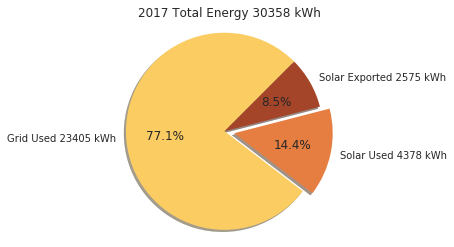

In [626]:
# Pie of energy production by source
sizes = [df_impexp_m['imp_kwh'].sum(), df_impexp_m['solar_utilised_kwh'].sum(), df_impexp_m['exp_kwh'].sum() ]
labels = 'Grid Used %d kWh' % sizes[0], 'Solar Used %d kWh' % sizes[1], 'Solar Exported %d kWh' % sizes[2]

explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45, colors=['#fbcc62', '#e67e41', '#a44529'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('2017 Total Energy %d kWh' % (df_impexp_m['imp_kwh'].sum() + df_impexp_m['solar_prod_kwh'].sum()))
plt.show()

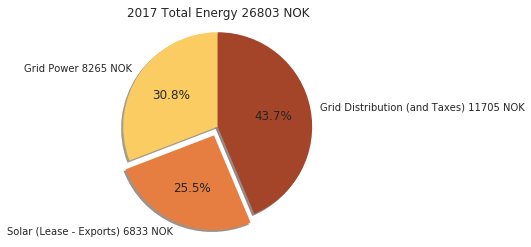

In [629]:
# Pie of energy costs by source
sizes = [df_impexp_m['imp_amount_with_vat'].sum(),
         df_impexp_m['solar_lease_amt'].sum() + df_impexp_m['exp_amount_with_vat'].sum(),
         df_impexp_m['blend_nettleie'].sum()
        ]

labels = 'Grid Power %.0f NOK' % sizes[0], 'Solar (Lease - Exports) %.0f NOK' % sizes[1], 'Grid Distribution (and Taxes) %.0f NOK' % sizes[2]

explode = (0, 0.1, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['#fbcc62', '#e67e41', '#a44529'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('2017 Total Energy %.0f NOK' % (df_impexp_m['blend_total'].sum()))
plt.show()